In [ ]:

from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from IPython import get_ipython
from IPython import display
import torch
import random
import re
import collections
import inspect
import os
import hashlib # Added missing import
import zipfile # Added missing import
import tarfile # Added missing import
import requests # Import the requests library

In [ ]:
import math
from torch import nn
from torch.nn import functional as F

In [ ]:

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def plot(X,Y=None,xlabel=None, ylabel=None, legend=[],xlim=None, ylim=None, xscale='linear',yscale='linear',fmts=('-','m--','g-.','r:'),figsize=(3.5,2.5),axes=None):
    def has_one_axis(X):
        return(hasattr(X,'ndim') and X.ndim == 1 or isinstance(X,list) and not hasattr(X[0],"__len__"))
    if has_one_axis(X): X=[X]
    if Y is None:
        X,Y=[[]]*len(X),X
    elif has_one_axis(Y):
        Y=[Y]
    if len(X) != len(Y):
        X=X*len(Y)
    set_figsize(figsize)
    if axes is None:
        axes=plt.gca()
    axes.cla()
    for x,y,fmt in zip (X,Y,fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend)

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.

        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), show_display=True): # Renamed display to show_display
        self.save_hyperparameters()
        self.show_display = show_display # Assign to a different attribute name


    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.show_display: # Use the new attribute name
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig) # Now this refers to the imported display module
        display.clear_output(wait=True)

In [ ]:
class Module(nn.Module, HyperParameters):
    def __init__(self,plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board= ProgressBoard()
    def squared_loss(self,y_hat,y):
        return(y_hat-y.reshape(y_hat.shape))**2/2
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural Network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        assert hasattr(self,'trainer'), 'Trainer is not inited'
        self.board.xlabel='epoch'
        if train:
            x= self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n=self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x=self.trainer.epoch+1
            n=self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        if isinstance(value, int):
            value=torch.tensor(value)
        self.board.draw(x,value.to('cpu').detach().numpy(), ('train_' if train else 'val_')+key, every_n=int(n))

    def training_step(self, batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self,batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=self.lr)
    def  apply_init(self, inputs, init=None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [ ]:
class DataModule(HyperParameters):
    def __init__(self, root='./data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self,train):
        i=slice(0,self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)


In [ ]:
def gpu(i=0):
    return torch.device(f'cuda:{i}')
def num_gpus():
    return torch.cuda.device_count()
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus_arg=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus=[gpu(i) for i in range(min(num_gpus_arg, num_gpus()))]
    def prepare_data(self,data):
        self.train_dataloader=data.train_dataloader()
        self.val_dataloader=data.val_dataloader()
        self.num_train_batches=len(self.train_dataloader)
        self.num_val_batches=(len(self.val_dataloader) if self.val_dataloader is not None else 0)
    def prepare_model(self,model):
        model.trainer=self
        model.board.xlim=[0,self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model=model
    def fit(self,model,data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim=model.configure_optimizers()
        self.epoch=0
        self.train_batch_idx=0
        self.val_batch_idx=0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0: # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    def prepare_batch(self,batch):
        if self.gpus:
            batch=[a.to(self.gpus[0]) for a in batch]
        return batch
    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm



In [ ]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
    def accuracy(Self, Y_hat, Y, averaged=True):
        Y_hat= Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds=Y_hat.argmax(axis=1).type(Y.dtype)
        compare=(preds==Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    def layer_summary(self,X_shape):
        X=torch.randn(*X_shape)
        for layer in self.net:
            X=layer(X)
            print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [ ]:
def download(url, folder='../data', sha1_hash=None):
    """Download a file to folder and return the local filepath."""
    if not url.startswith('http'):
    # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1])
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash:
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
            sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname
def extract(filename, folder=None):
    """Extract a zip/tar file into folder."""
    base_dir = os.path.dirname(filename)
    _, ext = os.path.splitext(filename)
    assert ext in ('.zip', '.tar', '.gz'), 'Only support zip/tar files.'
    if ext == '.zip':
        fp = zipfile.ZipFile(filename, 'r')
    else:
        fp = tarfile.open(filename, 'r')
    if folder is None:
        folder = base_dir
    fp.extractall(folder)

In [ ]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

class TimeMachine(DataModule):
  def _download(self):
    fname=download(DATA_URL+ 'timemachine.txt', self.root,'090b5e7e70c295757f55df93cb0a180b9691891a')
    with open(fname) as f:
      return f.read()
  def _preprocess(self,text):
    return re.sub('[^A-Za-z]+',' ',text).lower()
  def _tokenize(self,text):
    return list(text)
  def build(self, raw_text, vocab=None):
    tokens=self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab=Vocab(tokens)
    corpus=[vocab[token] for token in tokens]
    return corpus, vocab
  def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab=self.build(self._download())
    array=torch.tensor([corpus[i:i+num_steps+1] for i in range(len(corpus)-num_steps)])
    self.X, self.y=array[:,:-1], array[:,1:]
  def get_dataloader(self,train):
    idx=slice(0,self.num_train) if train else slice(self.num_train,self.num_train+self.num_val)
    return self.get_tensorloader((self.X,self.y),train,idx)


In [ ]:
class Vocab:
  def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
    if tokens and isinstance(tokens[0],list):
      tokens=[token for line in tokens for token in line]
    counter=collections.Counter(tokens)
    self.token_freqs=sorted(counter.items(), key=lambda x:x[1], reverse=True)
    self.idx_to_token=list(sorted(set(['<unk>']+reserved_tokens+[token for token, freq in self.token_freqs if freq>=min_freq])))
    self.token_to_idx={token:idx for idx, token in enumerate(self.idx_to_token)}
  def __len__(self):
    return len(self.idx_to_token)
  def __getitem__(self,tokens):
    if not isinstance(tokens,(list,tuple)):
      return self.token_to_idx.get(tokens,self.unk)
    return [self.__getitem__(token) for token in tokens]
  def to_tokens(self, indices):
    if hasattr(indices,'__len__') and len(indices)>1:
      return [self.idx_to_token[int(index)] for index in indices]
    return self.idx_to_token[indices]
  @property
  def unk(self):
    return self.token_to_idx['<unk>']

In [ ]:
class RNNScratch(Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W_xh=nn.Parameter(torch.randn(num_inputs,num_hiddens)*sigma)
    self.W_hh=nn.Parameter(torch.randn(num_hiddens,num_hiddens)*sigma)
    self.b_h=nn.Parameter(torch.zeros(num_hiddens))
  def forward(self, inputs, state=None):
    if state is None:
      state=torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
      state, =state
    outputs=[]
    for X in inputs:
      state=torch.tanh(torch.matmul(X, self.W_xh)+torch.matmul(state, self.W_hh)+self.b_h)
      outputs.append(state)
    return outputs,state

In [ ]:
class GRUScratch(Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    init_weight= lambda *shape: nn.Parameter(torch.randn(*shape)*sigma)
    triple = lambda: (init_weight(num_inputs, num_hiddens),
                      init_weight(num_hiddens, num_hiddens),
                      nn.Parameter(torch.zeros(num_hiddens)))
    self.W_xz, self.W_hz, self.b_z = triple()  # Update gate parameters
    self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate parameters
    self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state parameters
  def forward(self, inputs, H=None):
    if H is None:
      H=torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    outputs = []
    for X in inputs:
      Z = torch.sigmoid(torch.matmul(X,self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z)
      R = torch.sigmoid(torch.matmul(X,self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r)
      H_tilda = torch.tanh(torch.matmul(X,self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h)
      H = Z * H + (1 - Z) * H_tilda
      outputs.append(H)
    return outputs, H


In [ ]:
class RNNLMScratch(Classifier):
  def __init__(self, rnn, vocab_size, lr=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.init_params()
  def init_params(self):
    self.W_hq=nn.Parameter(torch.randn(self.rnn.num_hiddens, self.vocab_size)*self.rnn.sigma)
    self.b_q=nn.Parameter(torch.zeros(self.vocab_size))
  def training_step(self, batch):
    l=self.loss(self(*batch[:-1]), batch[-1])
    self.plot('ppl', torch.exp(l), train=True)
    return l
  def validation_step(self, batch):
    l=self.loss(self(*batch[:-1]), batch[-1])
    self.plot('ppl', torch.exp(l), train=False)
  def one_hot(self, X):
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)
  def output_layer(self, rnn_outputs):
    outputs=[torch.matmul(H,self.W_hq)+self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)
  def forward (self, X, state=None):
    embs=self.one_hot(X)
    rnn_outputs, _ =self.rnn(embs, state)
    return self.output_layer(rnn_outputs)
  def loss(self, Y_hat, Y):
    return F.cross_entropy(Y_hat.reshape(-1, Y_hat.shape[-1]), Y.reshape(-1))
  def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs =None, [vocab[prefix[0]]]
    for i in range(len(prefix)+num_preds-1):
      X=torch.tensor([[outputs[-1]]], device=device)
      embs=self.one_hot(X)
      rnn_outputs, state=self.rnn(embs, state)
      if i<len(prefix)-1:
        outputs.append(vocab[prefix[i+1]])
      else:
        Y=self.output_layer(rnn_outputs)
        outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


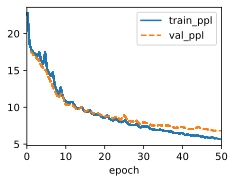

In [ ]:
data=TimeMachine(batch_size=1024, num_steps=32)
gru=GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model=RNNLMScratch(gru, vocab_size=len(data.vocab),lr=4)
trainer=Trainer(max_epochs=50, gradient_clip_val=1, num_gpus_arg=1)
trainer.fit(model,data)

In [ ]:
def cpu():
  """Get the CPU device."""
  return torch.device('cpu')
def try_gpu(i=0):
  if num_gpus() >= i + 1:
    return gpu(i)
  return cpu()

In [ ]:
model.predict('it has', 20, data.vocab, try_gpu())

'it has in the the the the '

Concise

In [ ]:
class RNN(Module):
  def __init__(self, num_inputs, num_hiddens):
    super().__init__()
    self.save_hyperparameters()
    self.rnn=nn.RNN(num_inputs, num_hiddens)
  def forward(self, inputs, H=None):
    return self.rnn(inputs, H)
class RNNLM(RNNLMScratch):
  def init_params(self):
    self.linear=nn.LazyLinear(self.vocab_size)
  def output_layer(self, hiddens):
    return self.linear(hiddens).swapaxes(0,1)

In [ ]:
class GRU(RNN):
  def __init__(self, num_inputs, num_hiddens):
    Module.__init__(self)
    self.save_hyperparameters()
    self.rnn=nn.GRU(num_inputs, num_hiddens)
  def forward(self, inputs, H_C=None):
    return self.rnn(inputs, H_C)
class RNNLM(RNNLMScratch):
  def init_params(self):
    self.linear=nn.LazyLinear(self.vocab_size)
  def output_layer(self, hiddens):
    return self.linear(hiddens).swapaxes(0,1)

In [ ]:
gru2=GRU(num_inputs=len(data.vocab), num_hiddens=32)
model2=RNNLM(gru2, vocab_size=len(data.vocab), lr=1)


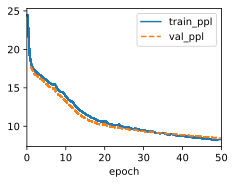

In [ ]:
trainer.fit(model2, data)

In [ ]:
model2.predict('it has', 20,data.vocab)

'it has the the the the the'